In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler 
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge , Lasso
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

In [139]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
# evalution model define

result = pd.DataFrame({'method':[],
                      'train_r2':[],
                      'test_r2':[],
                      'train_adj_r2':[],
                      'test_adj_r2':[],
                      'train_mae':[],
                      'test_mae':[]})

def Evalution(method, x_train, x_test, y_train, y_test):
    n_train, k_train = x_train.shape
    n_test, k_test = x_test.shape
    
    
    # model_fit
    model = LinearRegression()
    model.fit(x_train,y_train)
    
    # predict
    y_train_pred = model.predict(x_train)
    y_test_pred  = model.predict(x_test)
    
    #r2
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # adjr2
    train_adj_r2 =  1 - ((1- train_r2) *(n_train -1) / (n_train - k_train - 1))
    test_adj_r2 = 1 - ((1- test_r2) *(n_test -1) / (n_test - k_test - 1))
    
    # mae
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    temp_df = pd.DataFrame({'method':[method],
                      'train_r2':[train_r2],
                      'test_r2':[test_r2],
                      'train_adj_r2':[train_adj_r2],
                      'test_adj_r2':[test_adj_r2],
                      'train_mae':[train_mae],
                      'test_mae':[test_mae]})
    
    global result
    result = pd.concat([result, temp_df])
    
    return result 
    


## Baseline model

In [4]:
# drop the null values and then tts baseline model  

XX = train_df.dropna().drop(columns = 'Habitability_score')
YY = train_df.dropna()['Habitability_score']

In [5]:
x_train_f, x_test_f, y_train_f, y_test_f = tts(XX,YY, random_state = 42, test_size = 0.20)

In [6]:
x_train_f.shape, x_test_f.shape, y_train_f.shape, y_test_f.shape

((21582, 14), (5396, 14), (21582,), (5396,))

In [7]:
# droping the unnecessary columns named id 
x_train_f.drop(columns = 'Id', inplace = True)
x_test_f.drop(columns = 'Id', inplace = True)

In [8]:
cat_col = x_train_f.select_dtypes(include = "O").columns.tolist()
num_col = x_train_f.select_dtypes(exclude = "O").columns.tolist()

In [9]:
cat_col

['Property_Type',
 'Furnishing',
 'Power_Backup',
 'Water_Supply',
 'Crime_Rate',
 'Dust_and_Noise']

In [10]:
num_col

['Property_Area',
 'Number_of_Windows',
 'Number_of_Doors',
 'Frequency_of_Powercuts',
 'Traffic_Density_Score',
 'Air_Quality_Index',
 'Neighborhood_Review']

In [11]:
for i in cat_col:
    print(f'''{i}--- 
    {train_df[i].value_counts()}''')
    print()
    print()

Property_Type--- 
    Apartment             11673
Single-family home     9146
Duplex                 4671
Bungalow               3392
Container Home         2310
#R%$G&867               407
Name: Property_Type, dtype: int64


Furnishing--- 
    Semi_Furnished     16314
Unfurnished         8279
Fully Furnished     6178
Name: Furnishing, dtype: int64


Power_Backup--- 
    No               23796
Yes               7124
NOT MENTIONED      679
Name: Power_Backup, dtype: int64


Water_Supply--- 
    All time                   15585
Once in a day - Morning     7887
Once in a day - Evening     6300
Once in two days            1569
NOT MENTIONED                258
Name: Water_Supply, dtype: int64


Crime_Rate--- 
    Well below average        15533
Slightly below average     9334
Slightly above average     4216
Well above average         1887
Name: Crime_Rate, dtype: int64


Dust_and_Noise--- 
    Medium    26376
High       2572
Low        1652
Name: Dust_and_Noise, dtype: int64




In [12]:
## Encoding 

In [13]:
# sorting the columns in between ord and ohe
ohe_col = ['Property_Type','Power_Backup','Water_Supply']
ord_col = ['Furnishing','Crime_Rate','Dust_and_Noise']

In [14]:
ord = OrdinalEncoder(categories = [['Unfurnished','Semi_Furnished','Fully Furnished'],
                                   ['Well below average','Slightly below average','Slightly above average','Well above average'],
                                  ['Low','Medium','High']], handle_unknown = 'use_encoded_value', unknown_value = -1)

x_train_ord = pd.DataFrame(ord.fit_transform(x_train_f[ord_col]), index = x_train_f.index, columns = ord_col)
x_test_ord = pd.DataFrame(ord.transform(x_test_f[ord_col]), index = x_test_f.index, columns = ord_col)

In [15]:
ohe = OneHotEncoder(sparse_output = False,  handle_unknown ='ignore')
x_train_ohe = pd.DataFrame(ohe.fit_transform(x_train_f[ohe_col]), index = x_train_f.index, columns = ohe.get_feature_names_out())
x_test_ohe = pd.DataFrame(ohe.transform(x_test_f[ohe_col]), index = x_test_f.index, columns = ohe.get_feature_names_out())

In [16]:
x_train_f.shape

(21582, 13)

In [17]:
# concat ord ohe and num columns 

x_train_1 = pd.concat([pd.concat([x_train_ord,x_train_ohe], axis = 1), x_train_f[num_col]], axis = 1)
x_test_1 = pd.concat([pd.concat([x_test_ord,x_test_ohe], axis = 1), x_test_f[num_col]], axis = 1)

In [18]:
Evalution('baseline',x_train_1,x_test_1,y_train_f,y_test_f)

,method,train_r2,test_r2,train_adj_r2,test_adj_r2,train_mae,test_mae
0,baseline,0.584668,0.57545,0.584206,0.573553,7.32635,7.449752


## Impute Null Values

In [19]:
# checking is there any missing vlaues in data set or not and then find the the columns name that have na vlaues 
missing_value = train_df.isnull().mean() * 100
na_col = missing_value[missing_value>0].index

In [20]:
na_col

Index(['Number_of_Windows', 'Furnishing', 'Frequency_of_Powercuts',
       'Crime_Rate', 'Dust_and_Noise'],
      dtype='object')

In [21]:
# checking is there any duplicates in the dataset or not 
train_df.duplicated().sum()

0

In [22]:
x = train_df.drop(columns = 'Habitability_score')
y = train_df['Habitability_score']

In [23]:
x_train, x_test, y_train, y_test = tts(x,y, random_state = 42, test_size = 0.20)

In [24]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((25279, 14), (6320, 14), (25279,), (6320,))

In [25]:
# drop id column
x_train.drop(columns = 'Id', inplace = True)
x_test.drop(columns = 'Id', inplace = True)

C:\Users\HP\AppData\Local\Temp\ipykernel_10184\1567878777.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(), annot = True)


<Axes: >

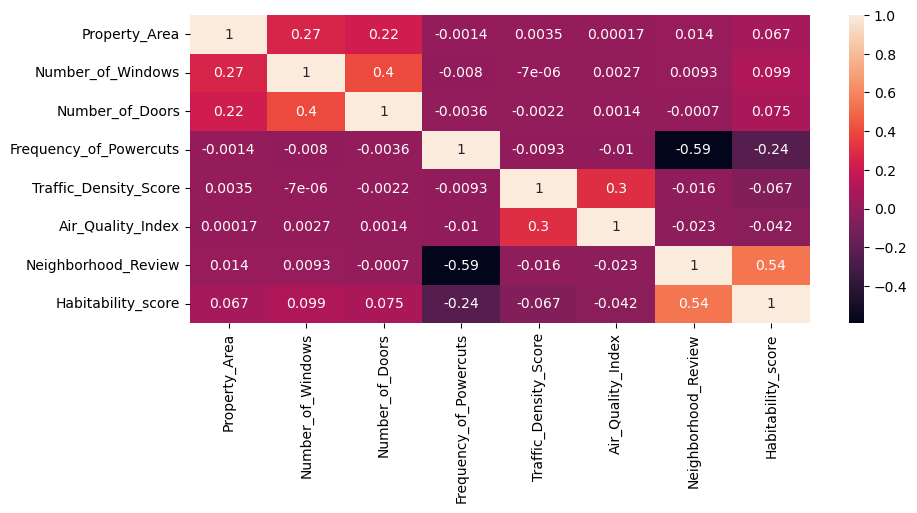

In [26]:
# checking data 
plt.figure(figsize = (10,4))
sns.heatmap(train_df.corr(), annot = True)

In [27]:
# handel missing values 

In [28]:
x_train[na_col].isnull().mean()*100

Number_of_Windows         4.074528
Furnishing                2.563393
Frequency_of_Powercuts    3.564223
Crime_Rate                1.922544
Dust_and_Noise            3.125124
dtype: float64

In [29]:
x_test[na_col].isnull().mean()*100

Number_of_Windows         4.794304
Furnishing                2.848101
Frequency_of_Powercuts    3.291139
Crime_Rate                2.262658
Dust_and_Noise            3.306962
dtype: float64

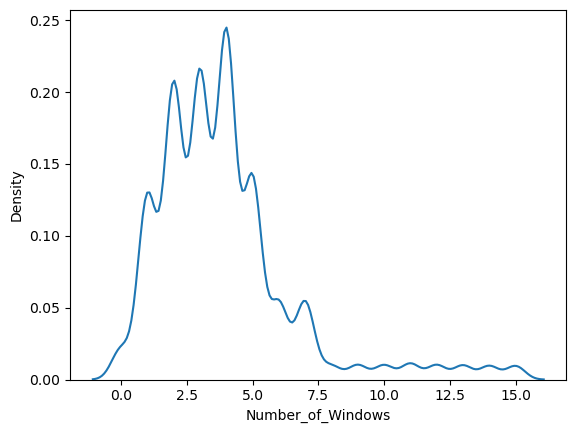

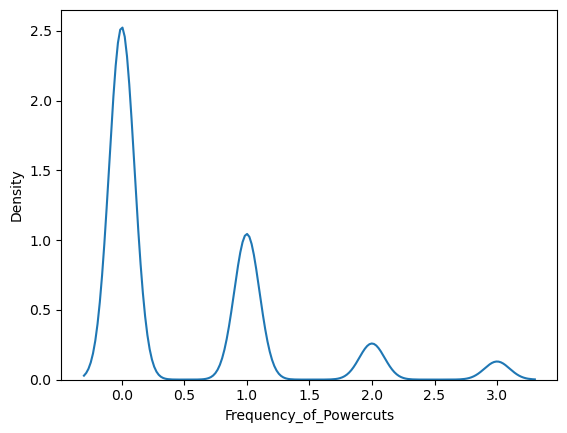

In [30]:
for i in x_train[na_col[0:3:2]].columns:
    sns.kdeplot(x_train[i])
    plt.show()

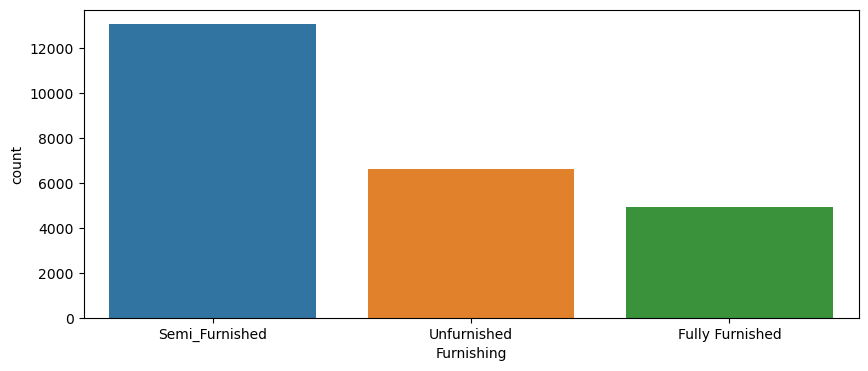

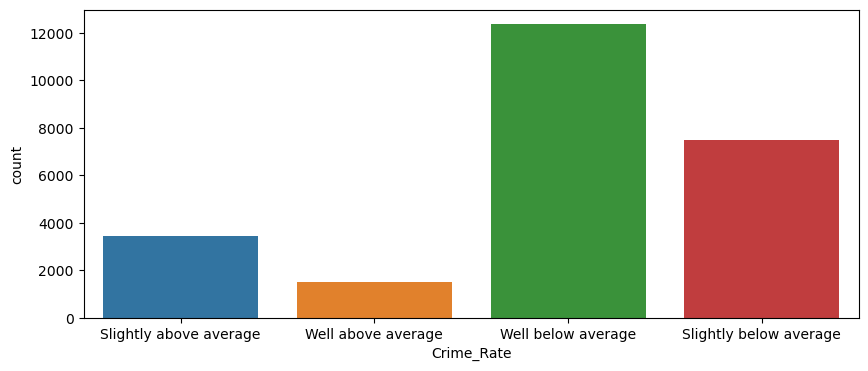

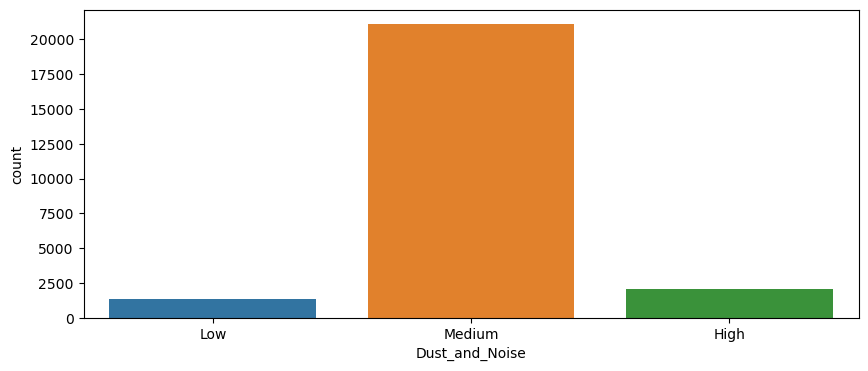

In [31]:
for i in x_train[na_col[[1,3,4]]].columns:
    plt.figure(figsize = (10,4))
    sns.countplot(x_train, x = i)
    plt.show()

In [32]:
# handel na value in Number_of_Windows

x_train['Number_of_Windows'] = x_train['Number_of_Windows'].fillna(round(x_train['Number_of_Windows'].mean(),0))
x_test['Number_of_Windows'] = x_test['Number_of_Windows'].fillna(round(x_train['Number_of_Windows'].mean(),0))

In [33]:
# handel na values in 2 col Furnishing

x_train['Furnishing'] = x_train['Furnishing'].fillna(x_train['Furnishing'].mode()[0])
x_test['Furnishing'] = x_test['Furnishing'].fillna(x_train['Furnishing'].mode()[0])

In [34]:
#  Frequency_of_Powercuts is co related with Neighborhood_Review so we take the avg power cut bassed on Neighborhood_Review and filled
# with null values

# exp - evg Frequency_of_Powercuts when  Neighborhood_Review 1 to 2 then with avg value with nan value   

In [35]:
# handel na values in 3 column Frequency_of_Powercuts

x_train[['Frequency_of_Powercuts','Neighborhood_Review']].sort_values(by = 'Frequency_of_Powercuts' , ascending = False)

,Frequency_of_Powercuts,Neighborhood_Review
17352,3.0,2.24
13629,3.0,2.93
14095,3.0,2.83
8154,3.0,2.90
11954,3.0,2.26
...,...,...
13986,NaN,2.27
7629,NaN,4.87
18431,NaN,4.17
8666,NaN,2.84


In [36]:
a = x_train[['Frequency_of_Powercuts','Neighborhood_Review']]
b = a.copy()

c = x_test[['Frequency_of_Powercuts','Neighborhood_Review']]
d = c.copy()

In [1]:
for i in range(5):
    if i == 0:
        mean = round(a[(a['Neighborhood_Review'] >= i) & (a['Neighborhood_Review'] <= i+1)].mean()[0],0)
        a[(a['Neighborhood_Review'] >= i) & (a['Neighborhood_Review'] <= i+1)] = a[(a['Neighborhood_Review'] >= i) & (a['Neighborhood_Review'] <= i+1)].fillna(mean)
        c[(c['Neighborhood_Review'] >= i) & (c['Neighborhood_Review'] <= i+1)] = c[(c['Neighborhood_Review'] >= i) & (c['Neighborhood_Review'] <= i+1)].fillna(mean)
    else:
        
        mean = round(a[(a['Neighborhood_Review'] > i) & (a['Neighborhood_Review'] <= i+1)].mean()[0],0)
        a[(a['Neighborhood_Review'] > i) & (a['Neighborhood_Review'] <= i+1)] = a[(a['Neighborhood_Review'] > i) & (a['Neighborhood_Review'] <= i+1)].fillna(mean)
        c[(c['Neighborhood_Review'] > i) & (c['Neighborhood_Review'] <= i+1)] = c[(c['Neighborhood_Review'] > i) & (c['Neighborhood_Review'] <= i+1)].fillna(mean)
        
        
        

In [38]:
x_train[['Frequency_of_Powercuts','Neighborhood_Review']] = a
x_test[['Frequency_of_Powercuts','Neighborhood_Review']] = c

In [39]:
x_train[na_col].isnull().sum()

Number_of_Windows           0
Furnishing                  0
Frequency_of_Powercuts      0
Crime_Rate                486
Dust_and_Noise            790
dtype: int64

In [40]:
x_test[na_col].isnull().sum()

Number_of_Windows           0
Furnishing                  0
Frequency_of_Powercuts      0
Crime_Rate                143
Dust_and_Noise            209
dtype: int64

In [41]:
# handel the 4 th column of missng values
x_train['Crime_Rate'] = x_train['Crime_Rate'].fillna(x_train['Crime_Rate'].mode()[0])
x_test['Crime_Rate'] = x_test['Crime_Rate'].fillna(x_train['Crime_Rate'].mode()[0])

In [42]:
# handel the 5 the columns of missing values 
x_train['Dust_and_Noise'] = x_train['Dust_and_Noise'].fillna(x_train['Dust_and_Noise'].mode()[0])
x_test['Dust_and_Noise'] = x_test['Dust_and_Noise'].fillna(x_train['Dust_and_Noise'].mode()[0])

In [43]:
# checking is there any null vlaues left 
x_train.isnull().sum()

Property_Type             0
Property_Area             0
Number_of_Windows         0
Number_of_Doors           0
Furnishing                0
Frequency_of_Powercuts    0
Power_Backup              0
Water_Supply              0
Traffic_Density_Score     0
Crime_Rate                0
Dust_and_Noise            0
Air_Quality_Index         0
Neighborhood_Review       0
dtype: int64

In [44]:
x_test.isnull().sum()

Property_Type             0
Property_Area             0
Number_of_Windows         0
Number_of_Doors           0
Furnishing                0
Frequency_of_Powercuts    0
Power_Backup              0
Water_Supply              0
Traffic_Density_Score     0
Crime_Rate                0
Dust_and_Noise            0
Air_Quality_Index         0
Neighborhood_Review       0
dtype: int64

In [45]:
num_col.append('Habitability_score')

In [46]:
# scaling the num col
std  = StandardScaler()
x_train_std = pd.DataFrame(std.fit_transform(x_train[num_col[0:-1]]), columns = num_col[0:-1], index = x_train.index)
x_test_std = pd.DataFrame(std.transform(x_test[num_col[0:-1]]), columns = num_col[0:-1], index = x_test.index)

In [47]:
# encoding 
ohe_col = ['Property_Type','Power_Backup','Water_Supply']
ord_col = ['Furnishing','Crime_Rate','Dust_and_Noise']

In [48]:
ord = OrdinalEncoder(categories = [['Unfurnished','Semi_Furnished','Fully Furnished'],
                                   ['Well below average','Slightly below average','Slightly above average','Well above average'],
                                  ['Low','Medium','High']], handle_unknown = 'use_encoded_value', unknown_value = -1)

x_train_ord = pd.DataFrame(ord.fit_transform(x_train[ord_col]), index = x_train.index, columns = ord_col)
x_test_ord = pd.DataFrame(ord.transform(x_test[ord_col]), index = x_test.index, columns = ord_col)

In [49]:
ohe = OneHotEncoder(sparse_output = False,  handle_unknown ='ignore')
x_train_ohe = pd.DataFrame(ohe.fit_transform(x_train[ohe_col]), index = x_train.index, columns = ohe.get_feature_names_out())
x_test_ohe = pd.DataFrame(ohe.transform(x_test[ohe_col]), index = x_test.index, columns = ohe.get_feature_names_out())

In [50]:
# concat 
x_train_2 = pd.concat([x_train_ord, x_train_ohe, x_train_std], axis = 1)
x_test_2 = pd.concat([x_test_ord, x_test_ohe, x_test_std], axis = 1)

In [51]:
# model evalution
Evalution('missing_value_impute and scaling',x_train_2, x_test_2, y_train, y_test)


,method,train_r2,test_r2,train_adj_r2,test_adj_r2,train_mae,test_mae
0,baseline,0.584668,0.575450,0.584206,0.573553,7.326350,7.449752
0,missing_value_impute and scaling,0.581353,0.567569,0.580955,0.565920,7.446236,7.299797


### Previous method + log of y



In [52]:
# model evalution
Evalution('missing_value_impute and scaling and log of y',x_train_2, x_test_2, np.log(y_train), np.log(y_test))


,method,train_r2,test_r2,train_adj_r2,test_adj_r2,train_mae,test_mae
0,baseline,0.584668,0.575450,0.584206,0.573553,7.326350,7.449752
0,missing_value_impute and scaling,0.581353,0.567569,0.580955,0.565920,7.446236,7.299797
0,missing_value_impute and scaling and log of y,0.544321,0.528285,0.543888,0.526486,0.131534,0.128183


## Polynomial features

In [53]:
from sklearn.preprocessing import PolynomialFeatures

In [54]:
poly = PolynomialFeatures((2,3))

In [55]:
x_train_poly = pd.DataFrame(poly.fit_transform(x_train[num_col[0:-1]]), index = x_train.index)
x_test_poly = pd.DataFrame(poly.transform(x_test[num_col[0:-1]]), index = x_test.index)

In [56]:
x_test_poly

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
17935,1.0,76729.0,277.0,831.0,554.0,1983.32,34625.0,969.50,1.0,3.0,...,367.061696,6408.2000,179.429600,111875.00,3132.5000,87.710000,1953125.0,54687.50,1531.2500,42.875000
17344,1.0,64009.0,506.0,506.0,759.0,1811.48,22264.0,738.76,4.0,4.0,...,367.061696,4511.3728,149.695552,55447.04,1839.8336,61.049024,681472.0,22612.48,750.3232,24.897088
12296,1.0,202500.0,450.0,450.0,0.0,3789.00,76050.0,1093.50,1.0,1.0,...,596.947688,11981.4916,172.278252,240483.62,3457.8414,49.719258,4826809.0,69403.23,997.9281,14.348907
12491,1.0,767376.0,5256.0,876.0,0.0,6710.16,132276.0,4134.72,36.0,6.0,...,449.455096,8860.0156,276.948832,174655.66,5459.4352,170.652544,3442951.0,107620.72,3364.0384,105.154048
6112,1.0,55225.0,235.0,705.0,0.0,1687.30,39715.0,881.25,1.0,3.0,...,370.146232,8712.3556,193.321500,205067.98,4550.3250,100.968750,4826809.0,107103.75,2376.5625,52.734375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9674,1.0,1016064.0,7056.0,3024.0,0.0,6390.72,88704.0,3255.84,49.0,21.0,...,254.840104,3537.2128,129.831788,49096.96,1802.0816,66.144586,681472.0,25013.12,918.0952,33.698267
28394,1.0,1375929.0,5865.0,4692.0,1173.0,7284.33,140760.0,4856.22,25.0,20.0,...,239.483061,4627.6920,159.655374,89424.00,3085.1280,106.436916,1728000.0,59616.00,2056.7520,70.957944
1864,1.0,254016.0,2016.0,1512.0,0.0,2711.52,58968.0,1774.08,16.0,12.0,...,155.720872,3386.4948,101.884288,73646.82,2215.6992,66.660352,1601613.0,48185.28,1449.6768,43.614208
11603,1.0,2965284.0,5166.0,3444.0,0.0,9918.72,173922.0,8248.38,9.0,6.0,...,191.102976,3350.9376,158.920704,58757.76,2786.6304,132.158016,1030301.0,48862.79,2317.3541,109.902239


In [57]:
# concat ohe ord and poly df
x_train_3 = pd.concat([x_train_ord,x_train_ohe,x_train_poly], axis = 1)
x_test_3 = pd.concat([x_test_ord,x_test_ohe,x_test_poly], axis = 1)

In [58]:
Evalution('polynomail featurs of num col without scaling and null values imputed', x_train_3.values, x_test_3.values, y_train,y_test)

,method,train_r2,test_r2,train_adj_r2,test_adj_r2,train_mae,test_mae
0,baseline,0.584668,0.575450,0.584206,0.573553,7.326350,7.449752
0,missing_value_impute and scaling,0.581353,0.567569,0.580955,0.565920,7.446236,7.299797
0,missing_value_impute and scaling and log of y,0.544321,0.528285,0.543888,0.526486,0.131534,0.128183
0,polynomail featurs of num col without scaling ...,0.615041,0.592340,0.613051,0.583777,7.056225,6.996530


### Scaling of Polynomial features

In [59]:
# StandardScaler, MinMaxScaler 
std = StandardScaler()
x_train_poly_std = pd.DataFrame(std.fit_transform(x_train_poly), index = x_train.index)
x_test_poly_std = pd.DataFrame(std.transform(x_test_poly), index = x_test.index)

In [60]:
x_train_4 = pd.concat([x_train_ord ,x_train_ohe ,x_train_poly_std], axis = 1)
x_test_4 = pd.concat([x_test_ord ,x_test_ohe ,x_test_poly_std], axis = 1)

In [61]:
Evalution('polynomail featurs of num col with scaling and null values imputed', x_train_4.values, x_test_4.values, y_train,y_test)

,method,train_r2,test_r2,train_adj_r2,test_adj_r2,train_mae,test_mae
0,baseline,0.584668,0.575450,0.584206,0.573553,7.326350,7.449752
0,missing_value_impute and scaling,0.581353,0.567569,0.580955,0.565920,7.446236,7.299797
0,missing_value_impute and scaling and log of y,0.544321,0.528285,0.543888,0.526486,0.131534,0.128183
0,polynomail featurs of num col without scaling ...,0.615041,0.592340,0.613051,0.583777,7.056225,6.996530
0,polynomail featurs of num col with scaling and...,0.615042,0.592339,0.613052,0.583776,7.056169,6.996416


## Outliers Handle 


In [62]:
x_train_ = x_train.copy()
x_test_ = x_test.copy()

In [63]:
# make a function that find that outlier in each column 
def CheckOutliers(df):
    columns = [ i for i in df.columns if df[i].dtype != "O"]
    ol= pd.DataFrame({'method':[],'Column':[],'No_of_outliers':[],'Persantage_of_outliers':[]})
    
    for col in columns:
        if -0.5 < df[col].skew() < 0.5:
            ub = df[col].mean() + (df[col].std())*3
            lb = df[col].mean() - (df[col].std())*3
            outliers = len(df[(df[col] > ub) | (df[col] < lb)][col])
            perchentage_of_Outlier = round((outliers/len(df)) * 100,2)
            temp = pd.DataFrame({'method':['Z-Score'],'Column':[col],'No_of_outliers':[outliers],
                                 'Persantage_of_outliers':[perchentage_of_Outlier]})
            
            ol = pd.concat([ol,temp]).reset_index(drop = True)
            
        else:
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lw = q1 - 1.5*(iqr)
            uw = q3 + 1.5*(iqr)
            
            outliers = len(df[(df[col] > uw) | (df[col] < lw)][col])
            perchentage_of_Outlier = round((outliers/len(df)) * 100,2)
            tempp = pd.DataFrame({'method':['IQR'],'Column':[col],'No_of_outliers':[outliers],
                                 'Persantage_of_outliers':[perchentage_of_Outlier]})
            
            ol = pd.concat([ol,tempp]).reset_index(drop = True)
    
    return ol

In [64]:
CheckOutliers(train_df)

,method,Column,No_of_outliers,Persantage_of_outliers
0,IQR,Property_Area,1372.0,4.34
1,IQR,Number_of_Windows,1602.0,5.07
2,IQR,Number_of_Doors,0.0,0.00
3,IQR,Frequency_of_Powercuts,977.0,3.09
4,IQR,Traffic_Density_Score,447.0,1.41
5,IQR,Air_Quality_Index,628.0,1.99
6,IQR,Neighborhood_Review,554.0,1.75
7,IQR,Habitability_score,2672.0,8.46


In [65]:
CheckOutliers(np.log(train_df[num_col]))

C:\Users\HP\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\HP\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,method,Column,No_of_outliers,Persantage_of_outliers
0,Z-Score,Property_Area,269.0,0.85
1,IQR,Number_of_Windows,571.0,1.81
2,Z-Score,Number_of_Doors,0.0,0.00
3,IQR,Frequency_of_Powercuts,0.0,0.00
4,IQR,Traffic_Density_Score,1025.0,3.24
5,IQR,Air_Quality_Index,960.0,3.04
6,IQR,Neighborhood_Review,1128.0,3.57
7,IQR,Habitability_score,2779.0,8.79


In [66]:
# after log transformation only 3 columns oulier reduace so we only transform 3 columns 

ot_col = ['Property_Area','Number_of_Windows','Frequency_of_Powercuts']

In [67]:
x_train_[ot_col] = np.log(x_train_[ot_col]+0.0000001)

In [68]:
x_test_[ot_col] = np.log(x_test_[ot_col]+0.0000001)

In [3]:
# create Polynomial features of num columns with outlier handel columns also

poly = PolynomialFeatures((2,3))

x_train_poly_ot = pd.DataFrame(poly.fit_transform(x_train_[num_col[0:-1]]), index = x_train_.index)
x_test_poly_ot = pd.DataFrame(poly.transform(x_test_[num_col[0:-1]]), index = x_test_.index)

In [70]:
# StandardScaler, MinMaxScaler 

std = StandardScaler()
x_train_poly_std_ot = pd.DataFrame(std.fit_transform(x_train_poly_ot), index = x_train.index)
x_test_poly_std_ot = pd.DataFrame(std.transform(x_test_poly_ot), index = x_test.index)

In [71]:
# concat ohe ord and std_polynomial featurs for new x_train
x_train_5 = pd.concat([x_train_ord ,x_train_ohe , x_train_poly_std_ot], axis = 1)
x_test_5 = pd.concat([x_test_ord , x_test_ohe , x_test_poly_std_ot], axis = 1)

In [72]:
Evalution('3 col ot handle and poly_std and impute ', x_train_5.values, x_test_5.values, y_train,y_test)

,method,train_r2,test_r2,train_adj_r2,test_adj_r2,train_mae,test_mae
0,baseline,0.584668,0.575450,0.584206,0.573553,7.326350,7.449752
0,missing_value_impute and scaling,0.581353,0.567569,0.580955,0.565920,7.446236,7.299797
0,missing_value_impute and scaling and log of y,0.544321,0.528285,0.543888,0.526486,0.131534,0.128183
0,polynomail featurs of num col without scaling ...,0.615041,0.592340,0.613051,0.583777,7.056225,6.996530
0,polynomail featurs of num col with scaling and...,0.615042,0.592339,0.613052,0.583776,7.056169,6.996416
0,3 col ot handle and poly_std and impute,0.618135,0.595425,0.616161,0.586927,7.042016,6.982998


### 'yeo-johnson method to handel the outliers

In [73]:
x_train_new = x_train.copy()
x_test_new = x_test.copy()

In [74]:
 
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')

x_train_new[num_col[0:-1]] = pt.fit_transform(x_train_new[num_col[0:-1]])
x_test_new[num_col[0:-1]] = pt.transform(x_test_new[num_col[0:-1]])

In [75]:
# create Polynomial features after outlier handel with yeo johnson method 

poly = PolynomialFeatures((2,3))

x_train_poly_yeo = pd.DataFrame(poly.fit_transform(x_train_new[num_col[0:-1]]), index = x_train_new.index)
x_test_poly_yeo = pd.DataFrame(poly.transform(x_test_new[num_col[0:-1]]), index = x_test_new.index)

In [76]:
# StandardScaler, MinMaxScaler 

std = StandardScaler()
x_train_poly_std_yeo = pd.DataFrame(std.fit_transform(x_train_poly_yeo), index = x_train.index)
x_test_poly_std_yeo = pd.DataFrame(std.transform(x_test_poly_yeo), index = x_test.index)

In [77]:
# concat ohe ord and std_polynomial featurs for new x_train

x_train_6 = pd.concat([x_train_ord ,x_train_ohe , x_train_poly_std_yeo], axis = 1)
x_test_6 = pd.concat([x_test_ord , x_test_ohe , x_test_poly_std_yeo], axis = 1)

In [78]:
Evalution('impute, ot handel yeo jhonson, poly feature, std scaling', x_train_6.values, x_test_6.values, y_train,y_test)

,method,train_r2,test_r2,train_adj_r2,test_adj_r2,train_mae,test_mae
0,baseline,0.584668,0.575450,0.584206,0.573553,7.326350,7.449752
0,missing_value_impute and scaling,0.581353,0.567569,0.580955,0.565920,7.446236,7.299797
0,missing_value_impute and scaling and log of y,0.544321,0.528285,0.543888,0.526486,0.131534,0.128183
0,polynomail featurs of num col without scaling ...,0.615041,0.592340,0.613051,0.583777,7.056225,6.996530
0,polynomail featurs of num col with scaling and...,0.615042,0.592339,0.613052,0.583776,7.056169,6.996416
0,3 col ot handle and poly_std and impute,0.618135,0.595425,0.616161,0.586927,7.042016,6.982998
0,"impute, ot handel yeo jhonson, poly feature, s...",0.614853,0.593960,0.612862,0.585431,7.047639,6.964144


### important Feature selection ( method = Recursive Feature Elimination 'RFE' )



In [91]:
from sklearn.feature_selection import RFE
lm = LinearRegression()
rfe = RFE(estimator= lm, n_features_to_select = 20)
selected_feature = rfe.fit_transform(x_train_2, y_train)
rfe.get_feature_names_out()

array(['Furnishing', 'Crime_Rate', 'Dust_and_Noise',
       'Property_Type_#R%$G&867', 'Property_Type_Apartment',
       'Property_Type_Bungalow', 'Property_Type_Container Home',
       'Property_Type_Duplex', 'Property_Type_Single-family home',
       'Power_Backup_NOT MENTIONED', 'Power_Backup_No',
       'Power_Backup_Yes', 'Water_Supply_All time',
       'Water_Supply_NOT MENTIONED',
       'Water_Supply_Once in a day - Evening',
       'Water_Supply_Once in a day - Morning',
       'Water_Supply_Once in two days', 'Number_of_Windows',
       'Frequency_of_Powercuts', 'Neighborhood_Review'], dtype=object)

In [92]:
# these 4 columns are least important columns 
least_important_col =['Air_Quality_Index','Traffic_Density_Score','Number_of_Doors','Property_Area']

In [93]:
x_train_N = x_train.copy()
x_test_N = x_test.copy()

In [94]:
# drop least important col

x_train_N.drop(columns = least_important_col, inplace = True)
x_test_N.drop(columns = least_important_col, inplace = True)

In [96]:
i_num_col =x_train_N.select_dtypes(exclude = 'O').columns.tolist()
i_num_col

['Number_of_Windows', 'Frequency_of_Powercuts', 'Neighborhood_Review']

In [97]:
otl_col = ['Number_of_Windows','Frequency_of_Powercuts']

In [98]:
x_train_N[otl_col] = np.log(x_train_N[otl_col]+0.0000001)

In [99]:
x_test_N[otl_col] = np.log(x_test_N[otl_col]+0.0000001)

In [100]:
# createPolynomial features of num columns with outlier handel columns also

poly = PolynomialFeatures((2,3))

x_train_poly_I = pd.DataFrame(poly.fit_transform(x_train_N[i_num_col]), index = x_train_.index)
x_test_poly_I = pd.DataFrame(poly.transform(x_test_N[i_num_col]), index = x_test_.index)

In [101]:
# StandardScaler, MinMaxScaler 

std = StandardScaler()
x_train_poly_std_I = pd.DataFrame(std.fit_transform(x_train_poly_I), index = x_train.index)
x_test_poly_std_I = pd.DataFrame(std.transform(x_test_poly_I), index = x_test.index)

In [102]:
# concat ohe ord and std_polynomial featurs for new x_train
x_train_7 = pd.concat([x_train_ord ,x_train_ohe , x_train_poly_std_I], axis = 1)
x_test_7 = pd.concat([x_test_ord , x_test_ohe , x_test_poly_std_I], axis = 1)

In [103]:
Evalution('important col with all previous good technique', x_train_7.values, x_test_7.values, y_train,y_test)

,method,train_r2,test_r2,train_adj_r2,test_adj_r2,train_mae,test_mae
0,baseline,0.584668,0.575450,0.584206,0.573553,7.326350,7.449752
0,missing_value_impute and scaling,0.581353,0.567569,0.580955,0.565920,7.446236,7.299797
0,missing_value_impute and scaling and log of y,0.544321,0.528285,0.543888,0.526486,0.131534,0.128183
0,polynomail featurs of num col without scaling ...,0.615041,0.592340,0.613051,0.583777,7.056225,6.996530
0,polynomail featurs of num col with scaling and...,0.615042,0.592339,0.613052,0.583776,7.056169,6.996416
0,3 col ot handle and poly_std and impute,0.618135,0.595425,0.616161,0.586927,7.042016,6.982998
0,"impute, ot handel yeo jhonson, poly feature, s...",0.614853,0.593960,0.612862,0.585431,7.047639,6.964144
0,important col with all previous good technique,0.608029,0.588135,0.607501,0.585907,7.131802,7.050533


## Highest r2 score that achived is 0.6181 in train and 0.5954 in test 
### with the method of (impute missing vlaues and handle 3 columns outliers and Polynomial features and standard scaling)
#### so finally we will choose this method to train the model

In [104]:
x_train = train_df.drop(columns = 'Habitability_score')
y_train = train_df['Habitability_score']
x_test = test_df.copy()

In [105]:
x_train.drop(columns = 'Id', inplace = True)
x_test.drop(columns = 'Id', inplace = True)

In [106]:
null_series = x_train.isnull().mean() * 100
null_col = null_series[null_series>0].index.tolist()
null_col

['Number_of_Windows',
 'Furnishing',
 'Frequency_of_Powercuts',
 'Crime_Rate',
 'Dust_and_Noise']

In [107]:
num_coll = x_train.select_dtypes(exclude = 'O').columns.tolist()
num_coll

['Property_Area',
 'Number_of_Windows',
 'Number_of_Doors',
 'Frequency_of_Powercuts',
 'Traffic_Density_Score',
 'Air_Quality_Index',
 'Neighborhood_Review']

In [108]:
# handel na value in Number_of_Windows

x_train['Number_of_Windows'] = x_train['Number_of_Windows'].fillna(round(x_train['Number_of_Windows'].mean(),0))
x_test['Number_of_Windows'] = x_test['Number_of_Windows'].fillna(round(x_train['Number_of_Windows'].mean(),0))

In [109]:
# handel na values in 2 col Furnishing

x_train['Furnishing'] = x_train['Furnishing'].fillna(x_train['Furnishing'].mode()[0])
x_test['Furnishing'] = x_test['Furnishing'].fillna(x_train['Furnishing'].mode()[0])

In [110]:
#  Frequency_of_Powercuts is co related with Neighborhood_Review so we take the avg power cut bassed on Neighborhood_Review and filled
# with null values

# exp - evg Frequency_of_Powercuts when  Neighborhood_Review 1 to 2 then with avg value with nan value   
# handel na values in 3 column Frequency_of_Powercuts

x_train[['Frequency_of_Powercuts','Neighborhood_Review']].sort_values(by = 'Frequency_of_Powercuts' , ascending = False)

,Frequency_of_Powercuts,Neighborhood_Review
6230,3.0,2.20
4465,3.0,1.00
20198,3.0,2.83
17778,3.0,0.72
17782,3.0,2.25
...,...,...
31475,NaN,2.26
31527,NaN,4.71
31537,NaN,3.48
31558,NaN,3.52


In [111]:
a = x_train[['Frequency_of_Powercuts','Neighborhood_Review']]
b = a.copy()

c = x_test[['Frequency_of_Powercuts','Neighborhood_Review']]
d = c.copy()

In [130]:
for i in range(5):
    if i == 0:
        mean = round(a[(a['Neighborhood_Review'] >= i) & (a['Neighborhood_Review'] <= i+1)].mean()[0],0)
        a[(a['Neighborhood_Review'] >= i) & (a['Neighborhood_Review'] <= i+1)] = a[(a['Neighborhood_Review'] >= i) & (a['Neighborhood_Review'] <= i+1)].fillna(mean)
        c[(c['Neighborhood_Review'] >= i) & (c['Neighborhood_Review'] <= i+1)] = c[(c['Neighborhood_Review'] >= i) & (c['Neighborhood_Review'] <= i+1)].fillna(mean)
    else:
        
        mean = round(a[(a['Neighborhood_Review'] > i) & (a['Neighborhood_Review'] <= i+1)].mean()[0],0)
        a[(a['Neighborhood_Review'] > i) & (a['Neighborhood_Review'] <= i+1)] = a[(a['Neighborhood_Review'] > i) & (a['Neighborhood_Review'] <= i+1)].fillna(mean)
        c[(c['Neighborhood_Review'] > i) & (c['Neighborhood_Review'] <= i+1)] = c[(c['Neighborhood_Review'] > i) & (c['Neighborhood_Review'] <= i+1)].fillna(mean)

In [113]:
x_train[['Frequency_of_Powercuts','Neighborhood_Review']] = a
x_test[['Frequency_of_Powercuts','Neighborhood_Review']] = c

In [114]:
x_train[na_col].isnull().sum()

Number_of_Windows           0
Furnishing                  0
Frequency_of_Powercuts      0
Crime_Rate                629
Dust_and_Noise            999
dtype: int64

In [115]:
x_test[na_col].isnull().sum()

Number_of_Windows           0
Furnishing                  0
Frequency_of_Powercuts      0
Crime_Rate                158
Dust_and_Noise            220
dtype: int64

In [116]:
# handel the 4 th column of missng values
x_train['Crime_Rate'] = x_train['Crime_Rate'].fillna(x_train['Crime_Rate'].mode()[0])
x_test['Crime_Rate'] = x_test['Crime_Rate'].fillna(x_train['Crime_Rate'].mode()[0])

In [117]:
# handel the 5 the columns of missing values 
x_train['Dust_and_Noise'] = x_train['Dust_and_Noise'].fillna(x_train['Dust_and_Noise'].mode()[0])
x_test['Dust_and_Noise'] = x_test['Dust_and_Noise'].fillna(x_train['Dust_and_Noise'].mode()[0])

In [118]:
# checking is there any null vlaues left 
x_train.isnull().sum()

Property_Type             0
Property_Area             0
Number_of_Windows         0
Number_of_Doors           0
Furnishing                0
Frequency_of_Powercuts    0
Power_Backup              0
Water_Supply              0
Traffic_Density_Score     0
Crime_Rate                0
Dust_and_Noise            0
Air_Quality_Index         0
Neighborhood_Review       0
dtype: int64

In [119]:
# checking is there any null vlaues left 
x_test.isnull().sum()

Property_Type             0
Property_Area             0
Number_of_Windows         0
Number_of_Doors           0
Furnishing                0
Frequency_of_Powercuts    0
Power_Backup              0
Water_Supply              0
Traffic_Density_Score     0
Crime_Rate                0
Dust_and_Noise            0
Air_Quality_Index         0
Neighborhood_Review       0
dtype: int64

In [120]:
CheckOutliers(x_train)

,method,Column,No_of_outliers,Persantage_of_outliers
0,IQR,Property_Area,1372.0,4.34
1,IQR,Number_of_Windows,1602.0,5.07
2,IQR,Number_of_Doors,0.0,0.00
3,IQR,Frequency_of_Powercuts,979.0,3.10
4,IQR,Traffic_Density_Score,447.0,1.41
5,IQR,Air_Quality_Index,628.0,1.99
6,IQR,Neighborhood_Review,554.0,1.75


In [121]:
CheckOutliers(np.log(x_train[num_coll]))

C:\Users\HP\anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\HP\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,method,Column,No_of_outliers,Persantage_of_outliers
0,Z-Score,Property_Area,269.0,0.85
1,IQR,Number_of_Windows,571.0,1.81
2,Z-Score,Number_of_Doors,0.0,0.00
3,IQR,Frequency_of_Powercuts,0.0,0.00
4,IQR,Traffic_Density_Score,1025.0,3.24
5,IQR,Air_Quality_Index,960.0,3.04
6,IQR,Neighborhood_Review,1128.0,3.57


In [122]:
# after log transformation only 3 columns oulier reduace so we only transform 3 columns 

ot_col = ['Property_Area','Number_of_Windows','Frequency_of_Powercuts']

In [123]:
x_train[ot_col] = np.log(x_train[ot_col]+0.0000001)
x_test[ot_col] = np.log(x_test[ot_col]+0.0000001)

In [124]:
poly = PolynomialFeatures((2,3))
x_train_p = pd.DataFrame(poly.fit_transform(x_train[num_coll]), index = x_train.index)
x_test_p = pd.DataFrame(poly.transform(x_test[num_coll]), index = x_test.index)

In [125]:
# StandardScaler, MinMaxScaler 

std = StandardScaler()
x_train_p_s = pd.DataFrame(std.fit_transform(x_train_p), index = x_train.index)
x_test_p_s = pd.DataFrame(std.transform(x_test_p), index = x_test.index)

In [126]:
# encoding 
ohe_col = ['Property_Type','Power_Backup','Water_Supply']
ord_col = ['Furnishing','Crime_Rate','Dust_and_Noise']

In [127]:
ord = OrdinalEncoder(categories = [['Unfurnished','Semi_Furnished','Fully Furnished'],
                                   ['Well below average','Slightly below average','Slightly above average','Well above average'],
                                  ['Low','Medium','High']], handle_unknown = 'use_encoded_value', unknown_value = -1)

x_train_ordd = pd.DataFrame(ord.fit_transform(x_train[ord_col]), index = x_train.index, columns = ord_col)
x_test_ordd = pd.DataFrame(ord.transform(x_test[ord_col]), index = x_test.index, columns = ord_col)

In [128]:
ohe = OneHotEncoder(sparse_output = False,  handle_unknown ='ignore')
x_train_ohee = pd.DataFrame(ohe.fit_transform(x_train[ohe_col]), index = x_train.index, columns = ohe.get_feature_names_out())
x_test_ohee = pd.DataFrame(ohe.transform(x_test[ohe_col]), index = x_test.index, columns = ohe.get_feature_names_out())

In [131]:
# creating x_train_fl with ohe ord and std_scl columns 

x_train_ff = pd.concat([x_train_ordd,x_train_ohee,x_train_p_s], axis = 1)
x_test_ff = pd.concat([x_test_ordd,x_test_ohee,x_test_p_s], axis = 1)

In [134]:
# model train 
l_model= LinearRegression()
l_model.fit(x_train_ff.values,y_train)

LinearRegression()

In [135]:
y_pred = l_model.predict(x_test_ff.values)

In [149]:
test_df['Habitability_score'] = y_pred

In [152]:
result_df = test_df[['Id',"Habitability_score"]]

In [153]:
# Export DataFrame to CSV
result_df.to_csv('output_file.csv', index=False)